# Imports

In [ ]:
!pip install lime

In [ ]:
!pip install numpy==1.25.0 --no-cache-dir --force-reinstall
!pip install jaxlib --no-cache-dir --force-reinstall
!pip install jax --no-cache-dir --force-reinstall

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 145.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.0
    Uninstalling numpy-1.25.0:
      Successfully uninstalled numpy-1.25.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.25.0 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.25.0 which is incompatible.
blosc2 3.3.1 requires numpy>=1.26, but you have numpy 1.25.0 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.25.0 which is incompatible.


ERROR: Operation cancelled by user
Traceback (most recent call last):
^C
^C


In [ ]:
!pip install lime shap

In [ ]:
!pip install alibi

INFO: pip is looking at multiple versions of thinc to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of thinc to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
INFO: pip is looking at multiple versions of spacy[lookups] to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.1/522.1 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 94.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 9.0 MB/s eta 0:00:00

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix
)
from matplotlib import ticker as mtick
from lime.lime_tabular import LimeTabularExplainer
from sklearn.inspection import PartialDependenceDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeRegressor, plot_tree
from alibi.explainers import ALE

# KNN Model

In [ ]:
X_train_final = pd.read_csv('/content/X_train_final.csv')
X_test_final = pd.read_csv('/content/X_test_final.csv')
y_train = pd.read_csv('/content/y_train_final.csv').squeeze()
y_test = pd.read_csv('/content/y_test_final.csv').squeeze()

In [ ]:
def evaluate_model1(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"\n{name} Evaluation")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(f"Precision: {precision_score(y_test, y_pred):.2f}")
    print(f"Recall: {recall_score(y_test, y_pred):.2f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.2f}")
    print(f"AUC: {roc_auc_score(y_test, y_pred):.2f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


KNN Evaluation
Accuracy: 0.90
Precision: 0.89
Recall: 0.93
F1 Score: 0.91
AUC: 0.90
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.87      0.89       544
           1       0.89      0.93      0.91       635

    accuracy                           0.90      1179
   macro avg       0.91      0.90      0.90      1179
weighted avg       0.90      0.90      0.90      1179



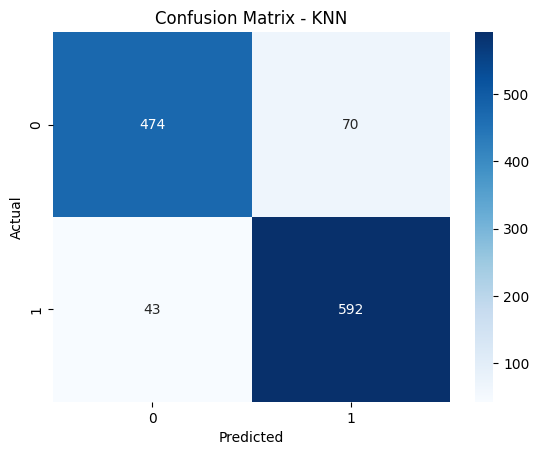

In [ ]:
knn_final = KNeighborsClassifier(n_neighbors=15)
knn_final.fit(X_train_final, y_train)
evaluate_model1("KNN", knn_final, X_test_final, y_test)

### LIME for KNN

In [ ]:
sample_instance = X_test_final.iloc[0]

explainer = LimeTabularExplainer(
    X_train_final.values,
    feature_names=X_train_final.columns.tolist(),
    class_names=['No Churn', 'Churn'],
    discretize_continuous=True
)

In [ ]:
print("\nLIME Explanation for KNN")
exp = explainer.explain_instance(sample_instance.values, knn_final.predict_proba)
exp.show_in_notebook()


LIME Explanation for KNN


This LIME explanation gives a local interpretation of one churn prediction:

* Churn Probability: The model predicts an 80% chance of churn.

* Top contributors to churn:

    * TotalCharges ≤ 247.16: Low total charges indicate the customer is relatively new.

    * tenure ≤ 4: Very short tenure strengthens the churn signal.

    * Negative discount_score: Suggests the customer isn’t receiving a competitive price.

    * High MonthlyCostPerTenure: Paying a lot early in the relationship contributes to churn.

* Features against churn:

    * Features like using a credit card for payment, and being in a family package appear to slightly reduce churn, but with minimal impact here.

This customer is flagged as high-risk due to low tenure, low total charges, and unfavorable pricing, classic early-stage churn indicators.

### PDP for KNN

In [ ]:
selected_feature = 'MonthlyCostPerTenure'
feature_index = X_train_final.columns.tolist().index(selected_feature)


PDP - KNN


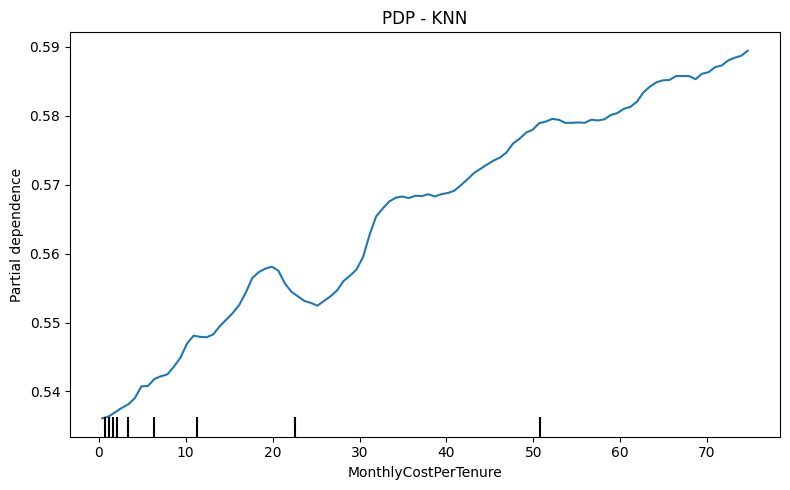

In [ ]:
print("\nPDP - KNN")
fig, ax = plt.subplots(figsize=(8, 5))
PartialDependenceDisplay.from_estimator(knn_final, X_test_final, [feature_index], ax=ax)
ax.set_title("PDP - KNN")
plt.tight_layout()
plt.show()

This PDP shows the relationship between MonthlyCostPerTenure and the predicted churn probability across all customers.

Overall Trend: As MonthlyCostPerTenure increases, churn probability gradually rises.

Interpretation: Customers who pay more per unit of tenure are more likely to churn.

Model Behavior: The plot is relatively smooth, though KNN typically shows more fluctuation—indicating moderate sensitivity to this feature.

This confirms that KNN associates higher cost per tenure with increased churn risk.

### ICE for KNN

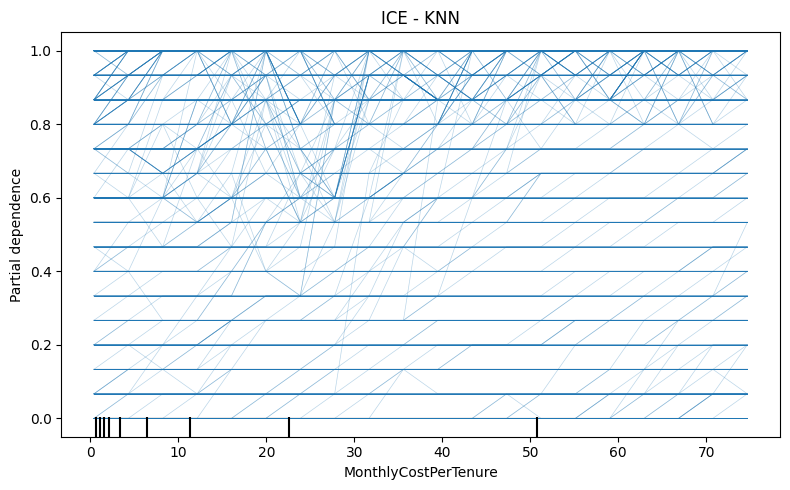

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
PartialDependenceDisplay.from_estimator(knn_final, X_test_final, [feature_index], kind='individual', grid_resolution=20, ax=ax)
ax.set_title("ICE - KNN")
plt.tight_layout()
plt.show()

This ICE plot for the KNN model shows how MonthlyCostPerTenure affects churn prediction for individual customers.

Flat Lines: Most lines are flat or have sudden jumps, indicating that predictions change abruptly for some customers, but remain constant for others.

Discontinuous Behavior: This pattern is expected in KNN, which makes decisions based on discrete neighbor sets rather than smooth trends.

High Churn Zones: Many customers have predictions close to 1.0 (high churn), regardless of MonthlyCostPerTenure, especially at higher values.

The ICE plot shows that KNN’s churn predictions can be abrupt and vary sharply per customer.

### ALE for KNN

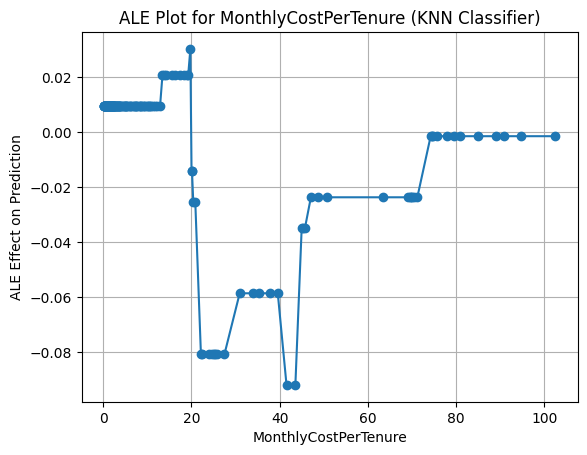

In [ ]:
predictor = lambda x: knn_final.predict_proba(x)[:, 1]

ale_explainer = ALE(predictor=predictor, feature_names=X_test_final.columns.tolist())

ale_exp = ale_explainer.explain(X_test_final.values)

feature_index = X_test_final.columns.tolist().index('MonthlyCostPerTenure')

plt.plot(ale_exp.feature_values[feature_index], ale_exp.ale_values[feature_index], marker='o')
plt.title('ALE Plot for MonthlyCostPerTenure (KNN Classifier)')
plt.xlabel('MonthlyCostPerTenure')
plt.ylabel('ALE Effect on Prediction')
plt.grid(True)
plt.show()

For lower values (below ~20), the effect on churn prediction is slightly positive.

Around 20–40, there is a sharp negative effect, meaning customers paying a medium MonthlyCostPerTenure are associated with a lower risk of churn.

After ~40, the effect slowly trends back upward toward neutral but stays less impactful.